In [13]:
import pandas as pd
import dill

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropConstantFeatures, DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from types import MethodType

from soccer_analytics.data.statsbomb import get_metadata, get_events
from soccer_analytics.data_split import split_by_time
from soccer_analytics.preprocessing import match_list_to_df, AngleNormalizer

In [2]:
competitions = get_metadata()

In [3]:
full_competitions = {
   "1. Bundesliga": ["2015/2016"],
    "FA Women's Super League": ["2018/2019", "2019/2020", "2020/2021"],
    "FIFA World Cup": ["2018", "2022"],
    "Indian Super league": ["2021/2022"],
    "La Liga": ["2015/2016"],
    "Ligue 1": ["2015/2016"],
    "Premier League": ["2015/2016"],
    "Serie A": ["2015/2016"],
    "UEFA Euro": ["2020"],
    "UEFA Women's Euro": ["2022"],
    "Women's World Cup": ["2019", "2023"]
}

In [4]:
matches_by_competition = {}
for competition in competitions:
    print(competition.name, len(competition.seasons))
    if competition.name in full_competitions:
        matches_by_competition[competition.name] = []
        for season in competition.seasons:
            print(f"    {season.name}: {len(season.matches)}")
            if season.name in full_competitions[competition.name]:
                matches_by_competition[competition.name].extend(get_events(
                    season, event_types=["shot"]
                ))

1. Bundesliga 1
    2015/2016: 306
Champions League 18
Copa del Rey 3
FA Women's Super League 3
    2020/2021: 131
    2019/2020: 87
    2018/2019: 108
FIFA U20 World Cup 1
FIFA World Cup 8
    2022: 64
    2018: 64
    1990: 1
    1986: 3
    1974: 6
    1970: 6
    1962: 1
    1958: 2
Indian Super league 1
    2021/2022: 115
La Liga 18
    2020/2021: 35
    2019/2020: 33
    2018/2019: 34
    2017/2018: 36
    2016/2017: 34
    2015/2016: 380
    2014/2015: 38
    2013/2014: 31
    2012/2013: 32
    2011/2012: 37
    2010/2011: 33
    2009/2010: 35
    2008/2009: 31
    2007/2008: 28
    2006/2007: 26
    2005/2006: 17
    2004/2005: 7
    1973/1974: 1
Liga Profesional 2
Ligue 1 1
    2015/2016: 377
North American League 1
NWSL 1
Premier League 2
    2015/2016: 380
    2003/2004: 38
Serie A 2
    2015/2016: 380
    1986/1987: 1
UEFA Euro 1
    2020: 51
UEFA Europa League 1
UEFA Women's Euro 1
    2022: 31
Women's World Cup 2
    2023: 64
    2019: 52


In [40]:
loss_info = []
coefficient_info = []
model_info = {}
train_data = {}
test_data = {}
for competition_name, matches in matches_by_competition.items():
    train_test_matches, _ = split_by_time(matches, test_frac=0.2)
    train_matches, test_matches = train_test_split(
        train_test_matches, test_size=0.2, random_state=235
    )
    train_df = match_list_to_df(train_matches)
    test_df = match_list_to_df(test_matches)
    train_data[competition_name] = train_df
    test_data[competition_name] = test_df
    data_prep_pipeline = Pipeline((
        ("encode_categories", OneHotEncoder(variables=["technique", "position"], drop_last=True)),
        ("drop_unused_columns", DropFeatures(["statsbomb_xg", "coordinates_x", "coordinates_y", "is_goal"])),
        ("drop_constant_columns", DropConstantFeatures()),
        ("create_angle_from_goal", AngleNormalizer(variable="angle_to_goal", new_variable="angle_from_goal")),
        ("passthrough", "passthrough"),
    ))
    model = LogisticRegression(penalty=None, max_iter=10000, random_state=315)
    train_df_transformed = data_prep_pipeline.fit_transform(train_df)
    test_df_transformed = data_prep_pipeline.transform(test_df)
    model.fit(train_df_transformed, train_df["is_goal"])
    test_probs = model.predict_proba(test_df_transformed)[:,1]
    
    mae = mean_absolute_error(test_df["is_goal"], test_probs)
    mae_statsbomb = mean_absolute_error(test_df["is_goal"], test_df["statsbomb_xg"])
    brier = brier_score_loss(test_df["is_goal"], test_probs)
    brier_statsbomb = brier_score_loss(test_df["is_goal"], test_df["statsbomb_xg"])
    loss_info.append({
        "competition": competition_name, 
        "mae": mae,
        "mae_statsbomb": mae_statsbomb,
        "brier": brier,
        "brier_statsbomb": brier_statsbomb
    })
    coefficient_info.extend(list(zip(
        [competition_name] * len(model.coef_[0]), train_df_transformed.columns, model.coef_[0]
    )))
    model_info[competition_name] = {"data_prep_pipeline": data_prep_pipeline, "model": model}
    
with open("simple_model.dill", "wb") as f:
    dill.dump(model_info, f)
loss_info = pd.DataFrame(loss_info)
coefficient_info = pd.DataFrame(coefficient_info, columns=["competition", "coef_name", "coef_value"])

In [41]:
loss_info

,competition,mae,mae_statsbomb,brier,brier_statsbomb
0,1. Bundesliga,0.159071,0.144773,0.080300,0.069194
1,FA Women's Super League,0.180210,0.165271,0.092913,0.088185
2,FIFA World Cup,0.145026,0.134978,0.069972,0.064855
3,Indian Super league,0.183942,0.151895,0.094218,0.081117
4,La Liga,0.166440,0.151398,0.085790,0.076159
5,Ligue 1,0.162668,0.145112,0.084874,0.077408
6,Premier League,0.152728,0.142464,0.074902,0.070332
7,Serie A,0.140389,0.134125,0.070098,0.069914
8,UEFA Euro,0.176905,0.172280,0.099426,0.092162
9,UEFA Women's Euro,0.157715,0.121463,0.093504,0.050070


In [42]:
coefficient_info.head()

,competition,coef_name,coef_value
0,1. Bundesliga,is_penalty,1.767217
1,1. Bundesliga,is_first_time,-0.271448
2,1. Bundesliga,distance_to_goal,-0.204031
3,1. Bundesliga,is_body_part_right_foot,1.846472
4,1. Bundesliga,is_body_part_left_foot,1.618581


In [48]:
bundesliga_x_pl_data = model_info["Premier League"]["data_prep_pipeline"].transform(
    test_data["1. Bundesliga"]
)
bundesliga_x_pl_predictions = model_info["Premier League"]["model"].predict_proba(bundesliga_x_pl_data)[:, 1]

bundesliga_x_bundes_data = model_info["1. Bundesliga"]["data_prep_pipeline"].transform(
    test_data["1. Bundesliga"]
)
bundesliga_x_bundes_predictions = model_info["1. Bundesliga"]["model"].predict_proba(bundesliga_x_bundes_data)[:, 1]

diff_data = bundesliga_x_bundes_data.copy()

diff_data["bundesliga_model"] = bundesliga_x_bundes_predictions
diff_data["premier_league_model"] = bundesliga_x_pl_predictions
diff_data["model_difference"] = bundesliga_x_bundes_predictions - bundesliga_x_pl_predictions

In [49]:
diff_data.sort_values(by="model_difference")

,is_penalty,is_first_time,distance_to_goal,is_body_part_right_foot,is_body_part_left_foot,is_body_part_head,is_body_part_other,technique_Normal,technique_Half Volley,technique_Volley,...,position_Left Center Midfield,position_Right Center Forward,position_Center Back,position_Left Wing Back,position_Right Wing Back,position_Right Attacking Midfield,angle_from_goal,bundesliga_model,premier_league_model,model_difference
12,False,False,3.476349,False,False,False,True,1,0,0,...,0,0,0,0,0,0,49.666858,0.203483,0.605336,-0.401853
9,False,False,6.326531,False,False,False,True,1,0,0,...,0,0,0,0,0,0,17.002853,0.156292,0.474742,-0.318451
5,False,True,4.815080,False,False,False,True,1,0,0,...,0,1,0,0,0,0,15.046392,0.169937,0.488088,-0.318151
20,False,True,14.082081,True,False,False,False,1,0,0,...,0,0,0,1,0,0,31.940691,0.000222,0.217831,-0.217609
9,False,False,10.087864,False,False,False,True,1,0,0,...,0,0,0,0,0,0,18.794165,0.101212,0.314605,-0.213393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,False,False,8.282814,True,False,False,False,1,0,0,...,0,1,0,0,0,0,13.616809,0.577043,0.357858,0.219185
23,False,False,13.483508,True,False,False,False,1,0,0,...,0,0,0,0,1,0,26.660069,0.382749,0.155536,0.227212
22,False,False,5.022450,True,False,False,False,1,0,0,...,0,1,0,0,0,0,9.743641,0.739869,0.501784,0.238084
2,False,False,10.342389,True,False,False,False,1,0,0,...,0,0,0,0,0,0,19.486130,0.508349,0.263318,0.245031


In [57]:
excluded_columns = ["bundesliga_model", "premier_league_model", "model_difference"]

In [64]:
diff_data[excluded_columns].describe()

,bundesliga_model,premier_league_model,model_difference
count,1314.000000,1314.000000,1314.000000
mean,0.112065,0.107759,0.004306
std,0.144054,0.130610,0.045341
min,0.000005,0.000026,-0.401853
25%,0.021986,0.025865,-0.012938
50%,0.064657,0.071421,-0.001856
75%,0.143452,0.139118,0.013593
max,0.872205,0.884200,0.330337


[Text(0.625, 0.875, 'is_body_part_other <= 0.5\nsquared_error = 0.002\nsamples = 1314\nvalue = 0.004'),
 Text(0.5, 0.625, 'position_Left Midfield <= 0.5\nsquared_error = 0.002\nsamples = 1310\nvalue = 0.005'),
 Text(0.25, 0.375, 'is_body_part_head <= 0.5\nsquared_error = 0.002\nsamples = 1239\nvalue = 0.008'),
 Text(0.125, 0.125, 'squared_error = 0.002\nsamples = 998\nvalue = 0.013'),
 Text(0.375, 0.125, 'squared_error = 0.001\nsamples = 241\nvalue = -0.013'),
 Text(0.75, 0.375, 'distance_to_goal <= 15.223\nsquared_error = 0.001\nsamples = 71\nvalue = -0.037'),
 Text(0.625, 0.125, 'squared_error = 0.0\nsamples = 23\nvalue = -0.069'),
 Text(0.875, 0.125, 'squared_error = 0.0\nsamples = 48\nvalue = -0.021'),
 Text(0.75, 0.625, 'squared_error = 0.004\nsamples = 4\nvalue = -0.313')]

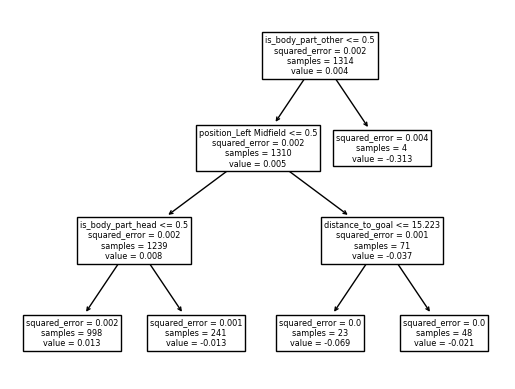

In [63]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
tree = DecisionTreeRegressor(max_depth=3, min_samples_split=20, random_state=156)
tree.fit(diff_data.drop(excluded_columns, axis=1), diff_data["model_difference"])
plot_tree(tree, feature_names=list(diff_data.drop(excluded_columns, axis=1).columns))